In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Sep 22 05:40 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# List available datasets.
!kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                   47MB  2019-08-24 15:36:54           1673  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                      2MB  2019-08-12 16:24:45          15548  
lakshyaag/india-trade-data                                India - Trade Data                                  1MB  2019-08-16 16:13:58           8190  
bradklassen/pga-tour-20102018-data                        PGA Tour Golf Data                                 94MB  2019-08-30 00:09:59           5945  
r3w0p4/bournemouth-venues                                 Venues in Bournemouth         

In [0]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d rednivrug/flower-recognition-he

flower-recognition-he.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip flower-recognition-he.zip

Archive:  flower-recognition-he.zip
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import pandas as pd

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pathlib

#from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import * 
from fastai.callbacks.hooks import *

In [0]:
path = pathlib.Path('data');path.ls()

[PosixPath('data/train.csv'),
 PosixPath('data/test'),
 PosixPath('data/model'),
 PosixPath('data/train'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/test.csv')]

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=90,p_affine=0.75,
                      max_lighting=0.5, max_warp=0.2, p_lighting=0.75,
                      xtra_tfms=[symmetric_warp(magnitude=(-0.3,0.3)),
                                 tilt(direction=(0,3),magnitude=0.4),
                                 pad(mode='reflection'),
                                 squish(),
                                 zoom(),
                                 cutout(n_holes=(1,5))])

In [0]:
np.random.seed(20)
data = ImageDataBunch.from_csv(path, folder='train', csv_labels='train.csv',suffix='.jpg',
                               valid_pct=0.15, test='test', ds_tfms=tfms,
                               size=224,bs = 64).normalize(imagenet_stats)

In [0]:
fbetaW = FBeta(beta=1, average="weighted")

In [0]:
train = pd.read_csv('/content/data/train.csv')

In [0]:
train.head()

,image_id,category
0,0,77
1,1,81
2,2,52
3,3,72
4,4,58


In [0]:
#learn = create_cnn(data,models.resnet101, metrics=[accuracy,fbetaW],pretrained=True).mixup()
learn = create_cnn(data, models.resnet152, metrics=[accuracy,fbetaW],model_dir="model/",
                  callback_fns=ShowGraph
                  ).mixup()

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [0]:
learn = learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 6.92E-03


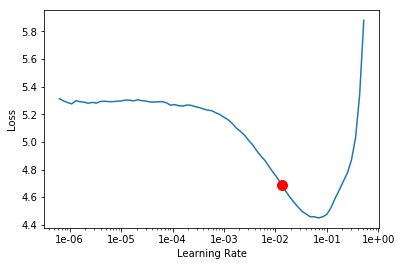

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,3.994498,2.788830,0.430421,0.367503,09:44
1,2.607144,1.129697,0.780295,0.759176,09:49
2,1.984712,0.531395,0.905430,0.902595,09:23
3,1.716198,0.363015,0.934556,0.933642,09:24
4,1.609022,0.270562,0.955052,0.954799,09:24
5,1.508255,0.240327,0.967278,0.966993,09:32
6,1.452537,0.200641,0.977346,0.977152,09:48
7,1.370134,0.185866,0.975189,0.974942,09:44
8,1.391908,0.160459,0.981302,0.981295,09:44
9,1.351414,0.153799,0.982740,0.982681,09:51


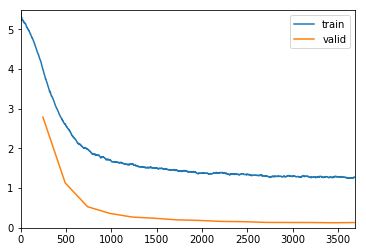

Better model found at epoch 0 with f_beta value: 0.36750316619873047.
Better model found at epoch 1 with f_beta value: 0.7591758370399475.
Better model found at epoch 2 with f_beta value: 0.9025951027870178.
Better model found at epoch 3 with f_beta value: 0.9336419701576233.
Better model found at epoch 4 with f_beta value: 0.9547985792160034.
Better model found at epoch 5 with f_beta value: 0.9669928550720215.
Better model found at epoch 6 with f_beta value: 0.9771522879600525.
Better model found at epoch 8 with f_beta value: 0.9812949299812317.
Better model found at epoch 9 with f_beta value: 0.9826814532279968.
Better model found at epoch 10 with f_beta value: 0.9855392575263977.
Better model found at epoch 12 with f_beta value: 0.9866427779197693.
Better model found at epoch 13 with f_beta value: 0.9873442053794861.
Better model found at epoch 14 with f_beta value: 0.98844975233078.


In [0]:
lr = 1e-03
learn.fit_one_cycle(15, slice(lr),wd = 0.2,callbacks=[SaveModelCallback(learn,every='improvement',monitor='f_beta',mode='max',name='resnet-152')]) 

In [0]:
learn = learn.load('resnet-152')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.29E-05


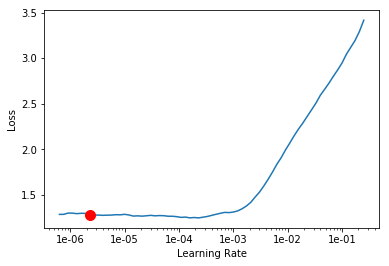

In [0]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.75E-07


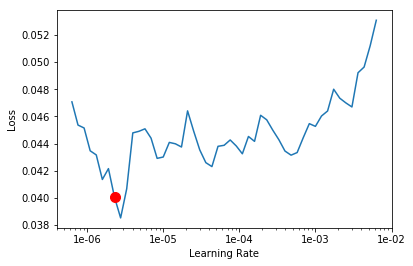

In [0]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.246960,0.131832,0.987774,0.987706,12:36
1,1.257451,0.130808,0.987774,0.987697,12:34
2,1.283418,0.126595,0.987415,0.987319,12:35
3,1.257577,0.131484,0.987774,0.987690,12:38


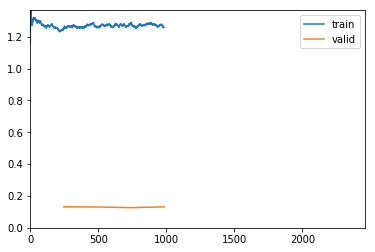

Better model found at epoch 0 with f_beta value: 0.9877062439918518.


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

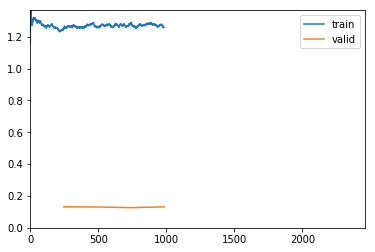

In [0]:
lr = 1e-06
learn.fit_one_cycle(10, slice(lr),wd = 0.2,callbacks=[SaveModelCallback(learn,every='improvement',monitor='f_beta',mode='max',name='resnet-152-2')]) 

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.085708,0.029823,0.994606,0.994661,10:05
1,0.094713,0.029346,0.994606,0.994629,09:57
2,0.080315,0.029181,0.994247,0.994301,10:00
3,0.083878,0.030005,0.994247,0.994262,09:59
4,0.084492,0.030466,0.993887,0.993927,09:58
5,0.085446,0.029369,0.994247,0.994271,09:59
6,0.086202,0.028805,0.994606,0.994629,10:01
7,0.084046,0.029615,0.994606,0.994661,10:08
8,0.084656,0.029857,0.993887,0.993903,10:04
9,0.088786,0.029556,0.994606,0.994646,10:09


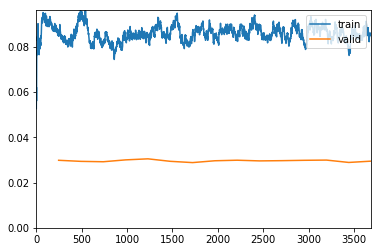

Better model found at epoch 0 with f_beta value: 0.9946608543395996.
Better model found at epoch 0 with f_beta value: 0.9946608543395996.


In [0]:
#lr = 1e-06
#learn.fit_one_cycle(15, slice(min_grad_lr),wd = 0.2,callbacks=[SaveModelCallback(learn,every='improvement',monitor='f_beta',mode='max',name='resnet-152')]) 
learn.fit_one_cycle(15, slice(2e-05),wd = 0.2,callbacks=[SaveModelCallback(learn,every='improvement',monitor='f_beta',mode='max',name='resnet-152-2')]) 

In [0]:
learn = learn.load('resnet-152')

In [0]:
learn.data = data

In [0]:
learn.unfreeze()

In [0]:
data = ImageDataBunch.from_csv(path, folder='train', csv_labels='train.csv',suffix='.jpg',
                               valid_pct=0.15, test='test', ds_tfms=tfms,
                               size=224,bs = 64).normalize(imagenet_stats)

In [0]:
learn.data = data

In [0]:
learn.freeze()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()

In [0]:
len(data.valid_ds)==len(losses)==len(idxs)

True

In [0]:
test = pd.read_csv(path/'test.csv')
test.head()

,image_id,category
0,18540,NaN
1,18541,NaN
2,18542,NaN
3,18543,NaN
4,18544,NaN


In [0]:
learn = learn.to_fp32()

In [0]:
#predsOne, yOne = learn.get_preds(ds_type=DatasetType.Test)
preds, y = learn.TTA(ds_type=DatasetType.Test)

In [0]:
y = torch.argmax(preds, dim=1)
y = y.numpy()
y = y+1

In [0]:
testList = os.listdir(path/'test')

In [0]:
testFold = pd.DataFrame({'image_id':[],'category':[]})

In [0]:
len(testList)

2010

In [0]:
flagger=0
for i in testList:
  if('Store' in i):
    print('found')
    break
  flagger=flagger+1

found


In [0]:
testList[flagger]

'.DS_Store'

In [0]:
iterator = 0
for imgName in testList:
    if(iterator<flagger):
      imgName = imgName.split('.')[0]
      testFold.loc[iterator,'image_id'] = imgName
      testFold.loc[iterator,'category'] = int(y[iterator])
      iterator = iterator + 1
    elif(iterator==flagger):
      iterator = iterator+1
    else:
      imgName = imgName.split('.')[0]
      testFold.loc[iterator-1,'image_id'] = imgName
      testFold.loc[iterator-1,'category'] = int(y[iterator-1])
      iterator = iterator + 1

In [0]:
for row in (test['image_id'].unique()):
    test.loc[test['image_id']==row,'category'] = int(testFold.loc[testFold['image_id']==str(row),'category'].values[0])

In [0]:
test['category'] = test['category'].astype('int')

In [0]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "garden__mixup_heavy_augment_2.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(test)